In [77]:
#model for ASL project
import pandas as pd

#change this when loading data
csv_file_path_train = '/Users/sofiautoft/ML/sign_mnist_train.csv'

train_data = pd.read_csv(csv_file_path_train)

print(train_data.shape)
train_data.head()

(27455, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [23]:
csv_file_path_test = '/Users/sofiautoft/ML/sign_mnist_test.csv'

test_data = pd.read_csv(csv_file_path_test)

print(test_data.shape)
test_data.head()

(7172, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [89]:
# locate labels into y_train variable
Y_train = train_data["label"]
# get rid of label
X_train = train_data.drop(labels = ["label"],axis = 1) 

#repeat for test data
Y_test = test_data["label"]
X_test = test_data.drop(labels = ["label"],axis = 1) 

In [92]:
num_to_letters = {}
for num in range(0, 25):
    letter = chr(num + 65)
    num_to_letters[num] = letter

print(num_to_letters)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'}


17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
3     1196
14    1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: label, dtype: int64

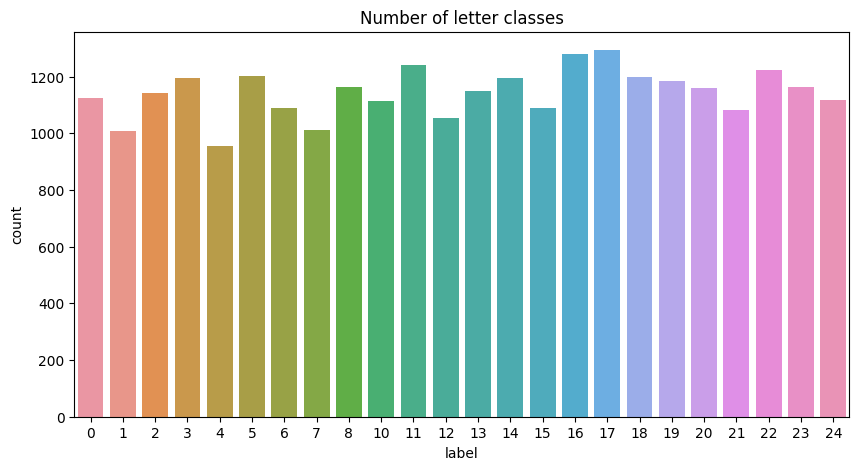

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

# visualize number of letters classes
plt.figure(figsize=(10,5))
g = sns.countplot(x = Y_train)
plt.title("Number of letter classes")
Y_train.value_counts()


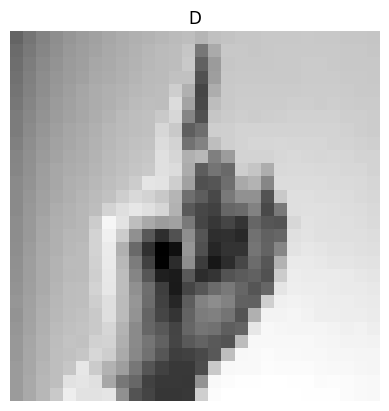

In [94]:
# plot some samples
img = X_train.iloc[0].values
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
key = train_data.iloc[0,0]
plt.title(num_to_letters[key])
plt.axis("off")
plt.show()

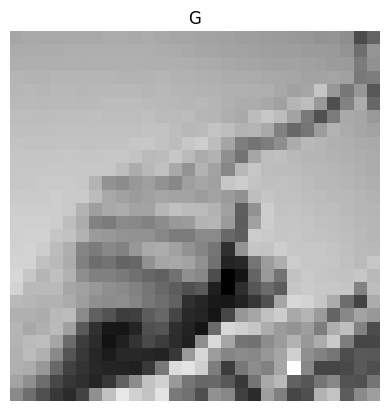

In [95]:
# plot some samples
img = X_train.iloc[1].values
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
key = train_data.iloc[1,0]
plt.title(num_to_letters[key])
plt.axis("off")
plt.show()

In [28]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
print("x_train shape: ",X_train.shape)
print("test shape: ",X_test.shape)

x_train shape:  (27455, 784)
test shape:  (7172, 784)


In [29]:
# Reshape
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
print("x_train shape: ",X_train.shape)
print("test shape: ",X_test.shape)

x_train shape:  (27455, 28, 28, 1)
test shape:  (7172, 28, 28, 1)


In [30]:
# Label Encoding (One Hot Encoding)
from tensorflow.keras.utils import to_categorical
Y_train_encoded = to_categorical(Y_train, num_classes = 25)
Y_test_encoded = to_categorical(Y_test, num_classes=25)

In [31]:
#Define model
# 
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(25, activation = "softmax"))


In [32]:
import tensorflow as tf

#Optimizer
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

#Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

#Calculate epochs & batch size
data = X_train.shape[0]
epochs = 95 #whole number options = 1, 5, 17, 19, 85, 95
batch_size = int(data / epochs)

In [33]:
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [34]:
X_train.shape
Y_train_encoded.shape

(27455, 25)

In [35]:
#keep track of how long training takes
import time
from tensorflow.keras.callbacks import Callback

class TrainingTimeCallback(Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        end_time = time.time()
        training_duration = end_time - self.start_time
        print("Training duration:", training_duration, "seconds")

# Create an instance of the custom callback
time_callback = TrainingTimeCallback()

In [36]:
# Fit the model
steps_per_epoch = int(X_train.shape[0] / batch_size)

history = model.fit(datagen.flow(X_train, Y_train_encoded, batch_size=batch_size),
                    epochs=epochs, 
                    validation_data=(X_test, Y_test_encoded), 
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[time_callback])

Epoch 1/95
95/95 [==============================] - 4s 42ms/step - loss: 3.0161 - accuracy: 0.1116 - val_loss: 2.3148 - val_accuracy: 0.3161
Epoch 2/95
95/95 [==============================] - 8s 82ms/step - loss: 2.1547 - accuracy: 0.3414 - val_loss: 1.2921 - val_accuracy: 0.6492
Epoch 3/95
95/95 [==============================] - 12s 131ms/step - loss: 1.6353 - accuracy: 0.4808 - val_loss: 0.8895 - val_accuracy: 0.7390
Epoch 4/95
95/95 [==============================] - 9s 94ms/step - loss: 1.3424 - accuracy: 0.5663 - val_loss: 0.6944 - val_accuracy: 0.8047
Epoch 5/95
95/95 [==============================] - 14s 149ms/step - loss: 1.1524 - accuracy: 0.6243 - val_loss: 0.5584 - val_accuracy: 0.8438
Epoch 6/95
95/95 [==============================] - 9s 99ms/step - loss: 1.0328 - accuracy: 0.6567 - val_loss: 0.5115 - val_accuracy: 0.8659
Epoch 7/95
95/95 [==============================] - 10s 104ms/step - loss: 0.9445 - accuracy: 0.6846 - val_loss: 0.4375 - val_accuracy: 0.8826
Epoch 8

In [37]:
#Save trained model
""" from tensorflow.keras.models import save_model

model.save("my_model.h5")  # Save the model to a file named "my_model.h5"
 """

' from tensorflow.keras.models import save_model\n\nmodel.save("my_model.h5")  # Save the model to a file named "my_model.h5"\n '